# notebook to get all features from pliers and save as csv
Uses jeffs pliers conda env

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("paper", "white")
from pyns import Neuroscout
import math

api = Neuroscout()

In [9]:
datasets = api.datasets.get()
print(f'dataset count = {len(api.datasets.get())}\n')
print('Datasets and IDs:\n')
for i in datasets:
    print(i['name'], i['id'])

dataset count = 12

Datasets and IDs:

Raiders 10
studyforrest 11
SchematicNarrative 20
SherlockMerlin 5
Sherlock 21
narratives 30
LearningTemporalStructure 19
Budapest 27
Life 9
ParanoiaStory 18
NaturalisticNeuroimagingDatabase 28
ReadingBrainProject 29


In [10]:
# ParanoiStory (audio only) LearningTemporalStructure and ReadingBrainProject should be excluded

#### get the id of a subject

In [11]:
subject = api.runs.get(dataset_id=8)[0]['subject']

### let's just look at budapest

In [12]:
api.runs.get(dataset_id=8, subject=subject)

[{'acquisition': None,
  'dataset_id': 8,
  'duration': 600.0000089406967,
  'id': 211,
  'number': None,
  'session': None,
  'subject': 'NDARYX592YYR',
  'task': 7,
  'task_name': 'movieDM'}]

In [13]:
#get the run number for just HBN, NDARYX592YYR, 7
run_id=api.runs.get(dataset_id=8, subject=subject)[0]['id']
run_duration=api.runs.get(dataset_id=8, subject=subject)[0]['duration']

### get just the non-fmriprep predictors and those that have a calculated mean (floats, ints, binary, etc)

In [14]:
def get_predictors(run_id):
    # input: a neuroscout run_id 
    # outputs:
    # - a pandas dataframe of predictors
    # - list of ids
    # - list of names
    # - list of modality
    predictors=api.predictors.get(run_id=run_id)
    predictor_ids = []
    predictor_names = []
    predictor_modality = []
    for i in predictors:
        if not i['source'] == 'fmriprep' and not i['mean'] == None and str(i['name']).find("bert") < 0:
            predictor_ids.append(i['id'])
            predictor_names.append(i['name'])
            try:
                predictor_modality.append(i['extracted_feature']['modality'])
            except:
                predictor_modality.append(None)
                
    df_predictors=pd.DataFrame(data= np.array([predictor_ids,predictor_modality,predictor_names]).T , columns=['id','modality','names'])
    df_predictors = df_predictors.sort_values(by=['id','names','modality'])
    predictor_ids= df_predictors['id'].to_numpy()
    predictor_names= df_predictors['names'].to_numpy()
    predictor_modality= df_predictors['modality'].to_numpy()



    return(df_predictors, predictor_ids, predictor_names, predictor_modality)

In [15]:
df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)

### load into pandas df, sort predictors by id, name, modality

#### how many values are in each predictor??

load an event into df, sort it by onset

In [16]:
def get_timeseries(predictor_ids,run_id,run_duration):
    # input: list of predictor IDs
    # output: an array of predictors as 1 hz timeseries
    #
    ### given an event... convert it from duration onset value to timeseries
    # - sort it (the dicts are out of order)
    # - convert to timeseries
    # - resample it to 1 hz now as a start
    all_feats = []
    for pred_id in predictor_ids:
        an_event=api.predictor_events.get(predictor_id=pred_id,run_id=run_id,stimulus_timing=True)
        data = np.zeros((int(run_duration)))
        for i in an_event:
            start = round(i['onset'])
            stop = start + math.ceil(i['duration'])
            value = i['value']
            #onset=round(onset)
            try:
                data[start:stop]=value
            except:
                #print()
                print(f'skipped {value}')

        all_feats.append(data)
    all_feats = np.asarray(all_feats)
    return(all_feats)
    #all_feats is length = # predictors each predictor is size = run duration

In [17]:
all_feats = get_timeseries(predictor_ids,run_id,run_duration)

df = pd.DataFrame(data=all_feats.T,columns =predictor_names)

#### Export to csv

In [14]:
#df.to_csv('../sourcedata/data/HBN/features/DM_pliers_all.csv')

In [19]:
df

,brightness,sharpness,face_detectionConfidence,face_landmarkingConfidence,abstract,action,alphabet,animal,architecture,art,...,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,vibrance,pitch,uncertainty
0,0.246131,1.0,0.000000,0.000000,0.167749,0.363600,0.002034,0.093345,0.533596,0.722260,...,-2.894316,-0.286717,6.342724,5.425536,0.909868,1.663460,4.637609,501.776222,0.157995,0.943466
1,0.243845,1.0,0.000000,0.000000,0.204442,0.388526,0.003572,0.147960,0.576969,0.758181,...,8.469676,-4.424966,5.635565,5.956702,-0.705075,4.817046,-0.041792,503.895218,0.377936,0.036005
2,0.244726,1.0,0.000000,0.000000,0.214081,0.381101,0.003139,0.108687,0.503560,0.803089,...,2.831864,-2.648869,-0.701678,-4.219223,4.170469,6.358319,-4.099131,508.354185,0.217259,0.343174
3,0.258668,1.0,0.000000,0.000000,0.126873,0.236590,0.003892,0.105058,0.581153,0.826734,...,-6.274574,-6.064760,-6.904429,-5.554349,-1.078951,2.417915,-5.254695,502.173525,0.153751,0.210115
4,0.268842,1.0,0.000000,0.000000,0.264085,0.385225,0.003718,0.181262,0.641755,0.853740,...,-3.418450,-7.354648,-6.871152,-2.616362,2.651057,-0.229634,-5.254941,530.951346,0.235832,0.319509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.106606,1.0,0.000000,0.000000,0.898762,0.517553,0.002320,0.120638,0.291205,0.744076,...,15.911509,7.112349,12.356004,7.507671,-5.595244,-6.956372,-5.310825,104.029311,0.434843,0.176041
596,0.329696,1.0,0.000000,0.000000,0.294298,0.428923,0.001047,0.276501,0.052066,0.650944,...,11.524013,7.770943,7.806584,3.544562,-2.694659,-2.387859,-6.526293,478.908754,0.317175,0.916448
597,0.329386,1.0,0.615383,0.130395,0.405134,0.461771,0.001875,0.109203,0.083333,0.661233,...,4.011791,4.093169,4.888222,1.624974,2.472670,2.027416,1.623478,464.330886,0.206460,0.915584
598,0.141205,1.0,0.000000,0.000000,0.932255,0.149778,0.002502,0.041972,0.003888,0.800101,...,-2.619781,0.160768,4.344271,3.139183,4.333610,7.584646,10.968047,191.240936,0.191943,0.958853


In [21]:
import dcor


CPU times: user 1min 27s, sys: 5.16 s, total: 1min 32s
Wall time: 2min 3s


Text(0.5, 1.0, 'Despicable Me, dcor clustermap')

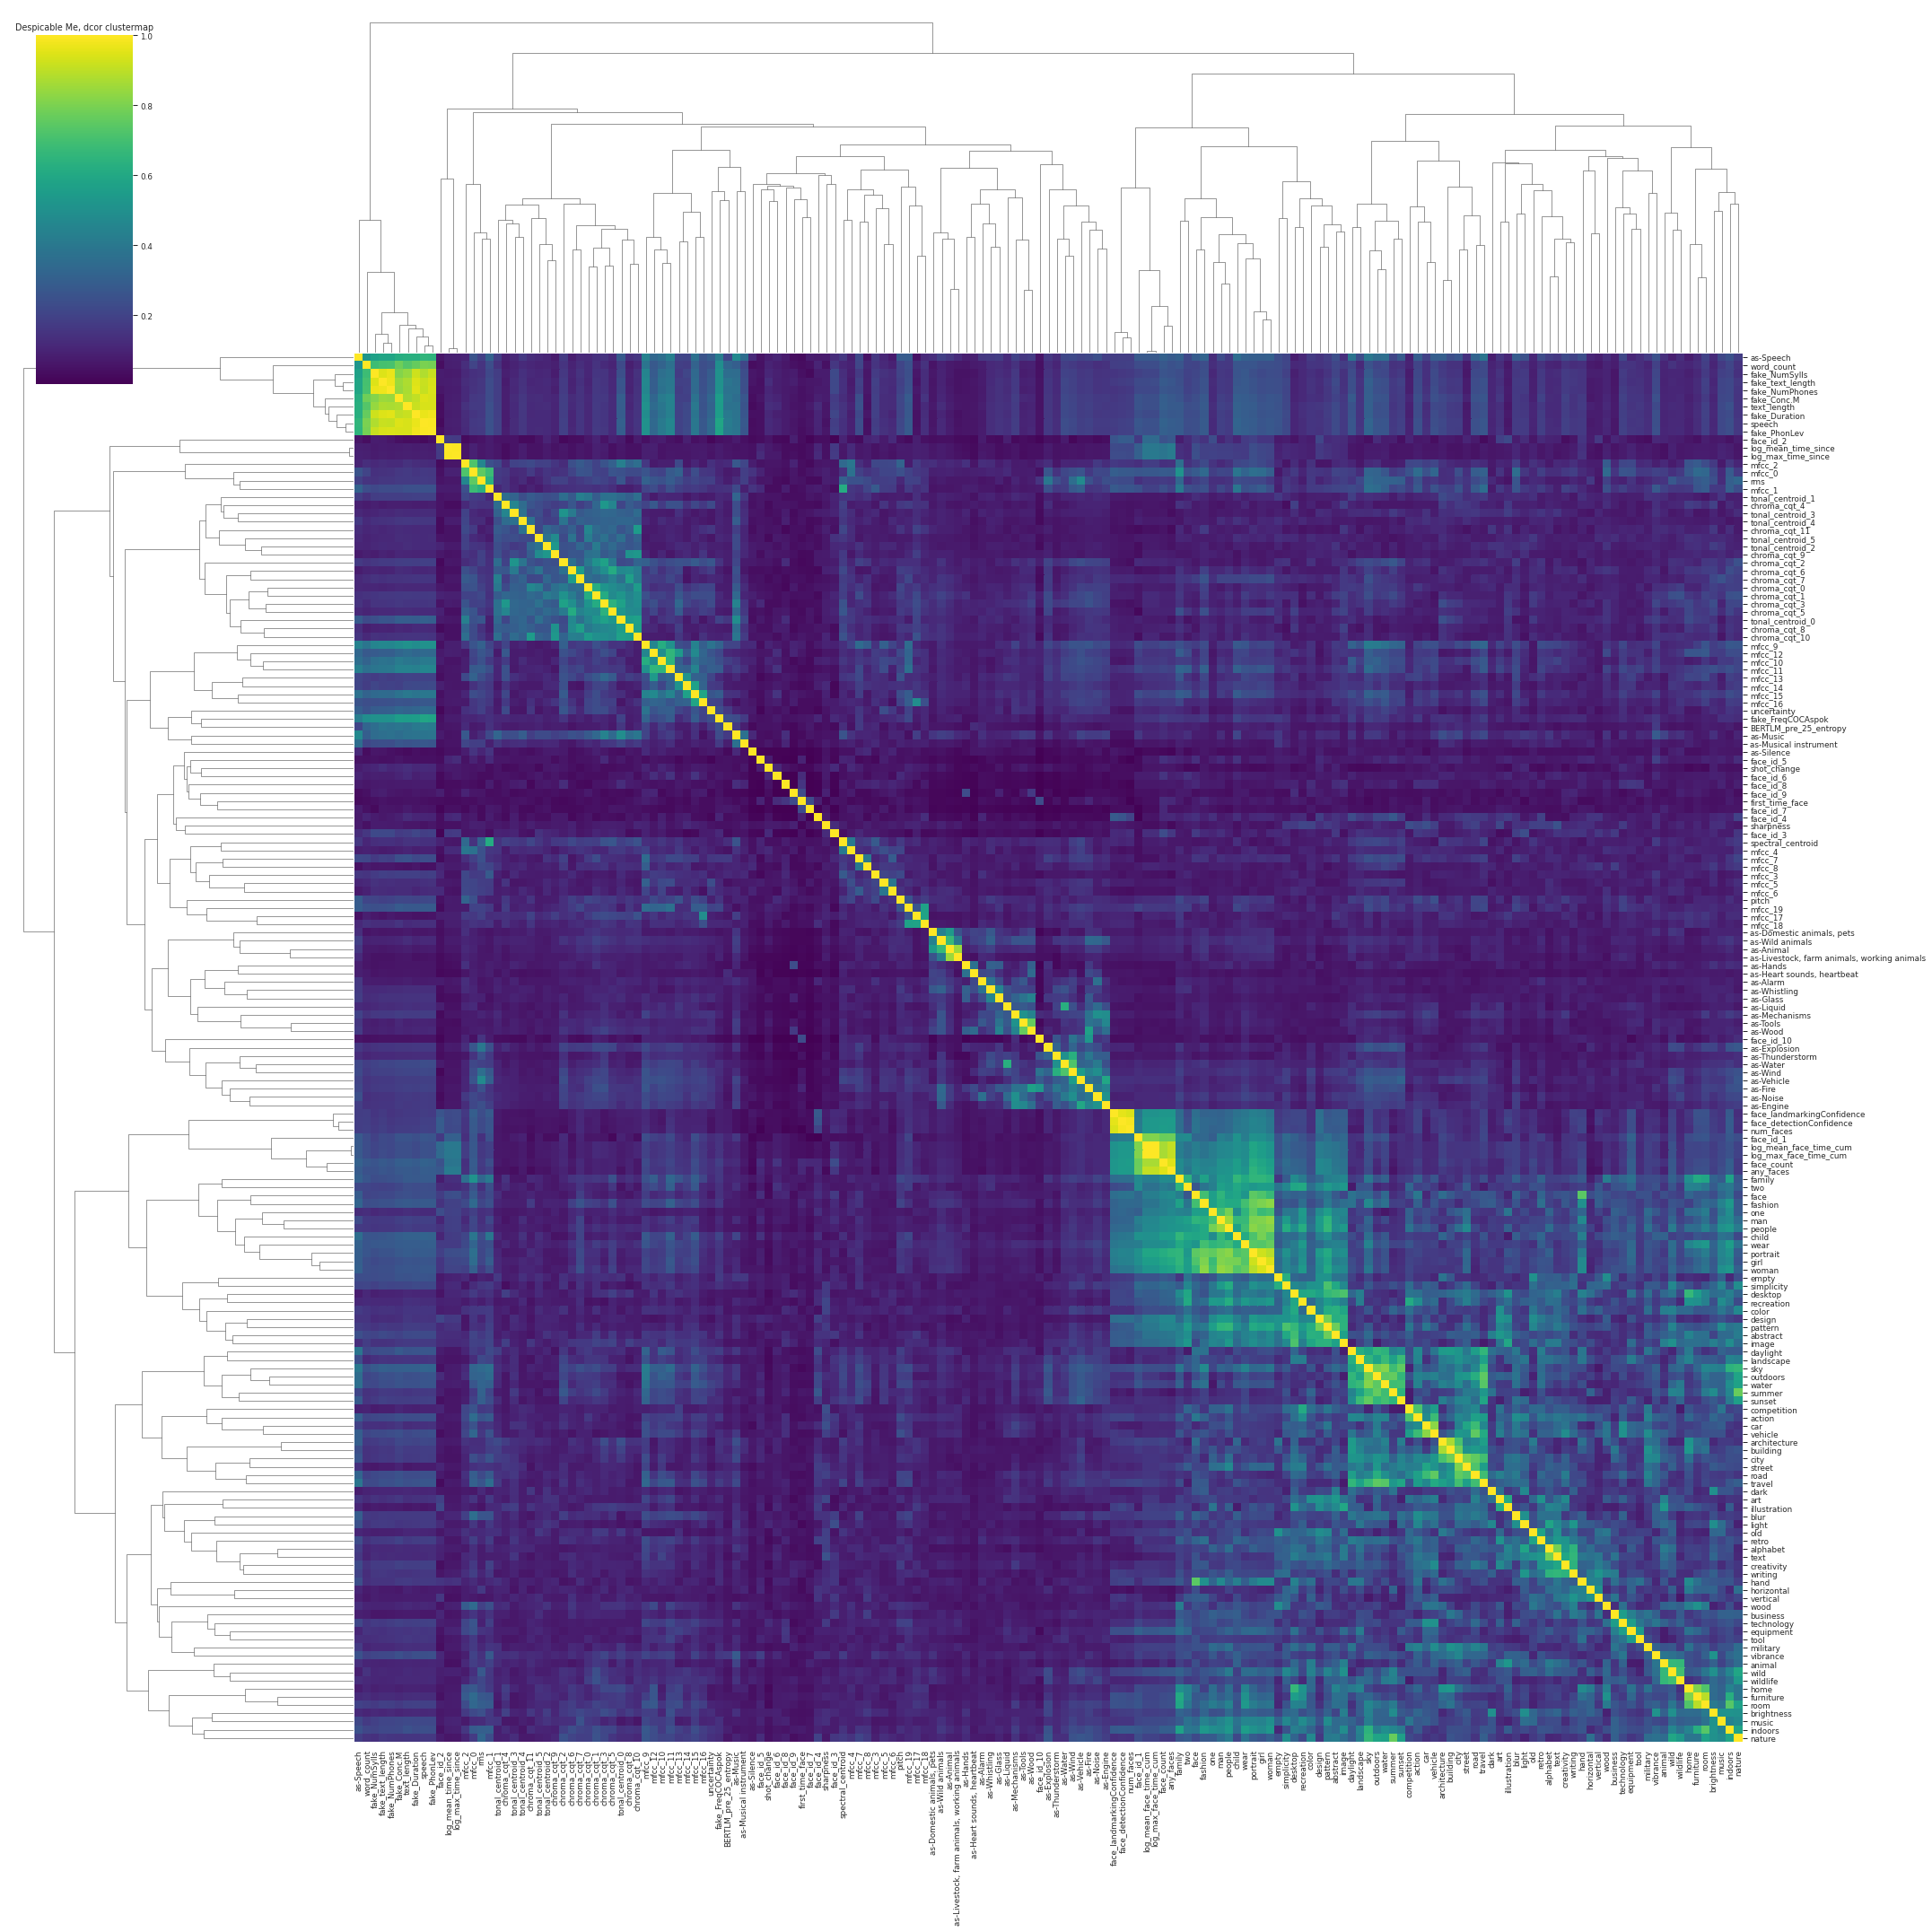

In [23]:

%time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
dcor_matrix = result.values
sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
plt.title(f'Despicable Me, dcor clustermap')
#plt.savefig(f'../outputs/dcor_{task_name}.png')
#plt.close()

Text(0.5, 1.0, 'Despicable Me correlation matrix')

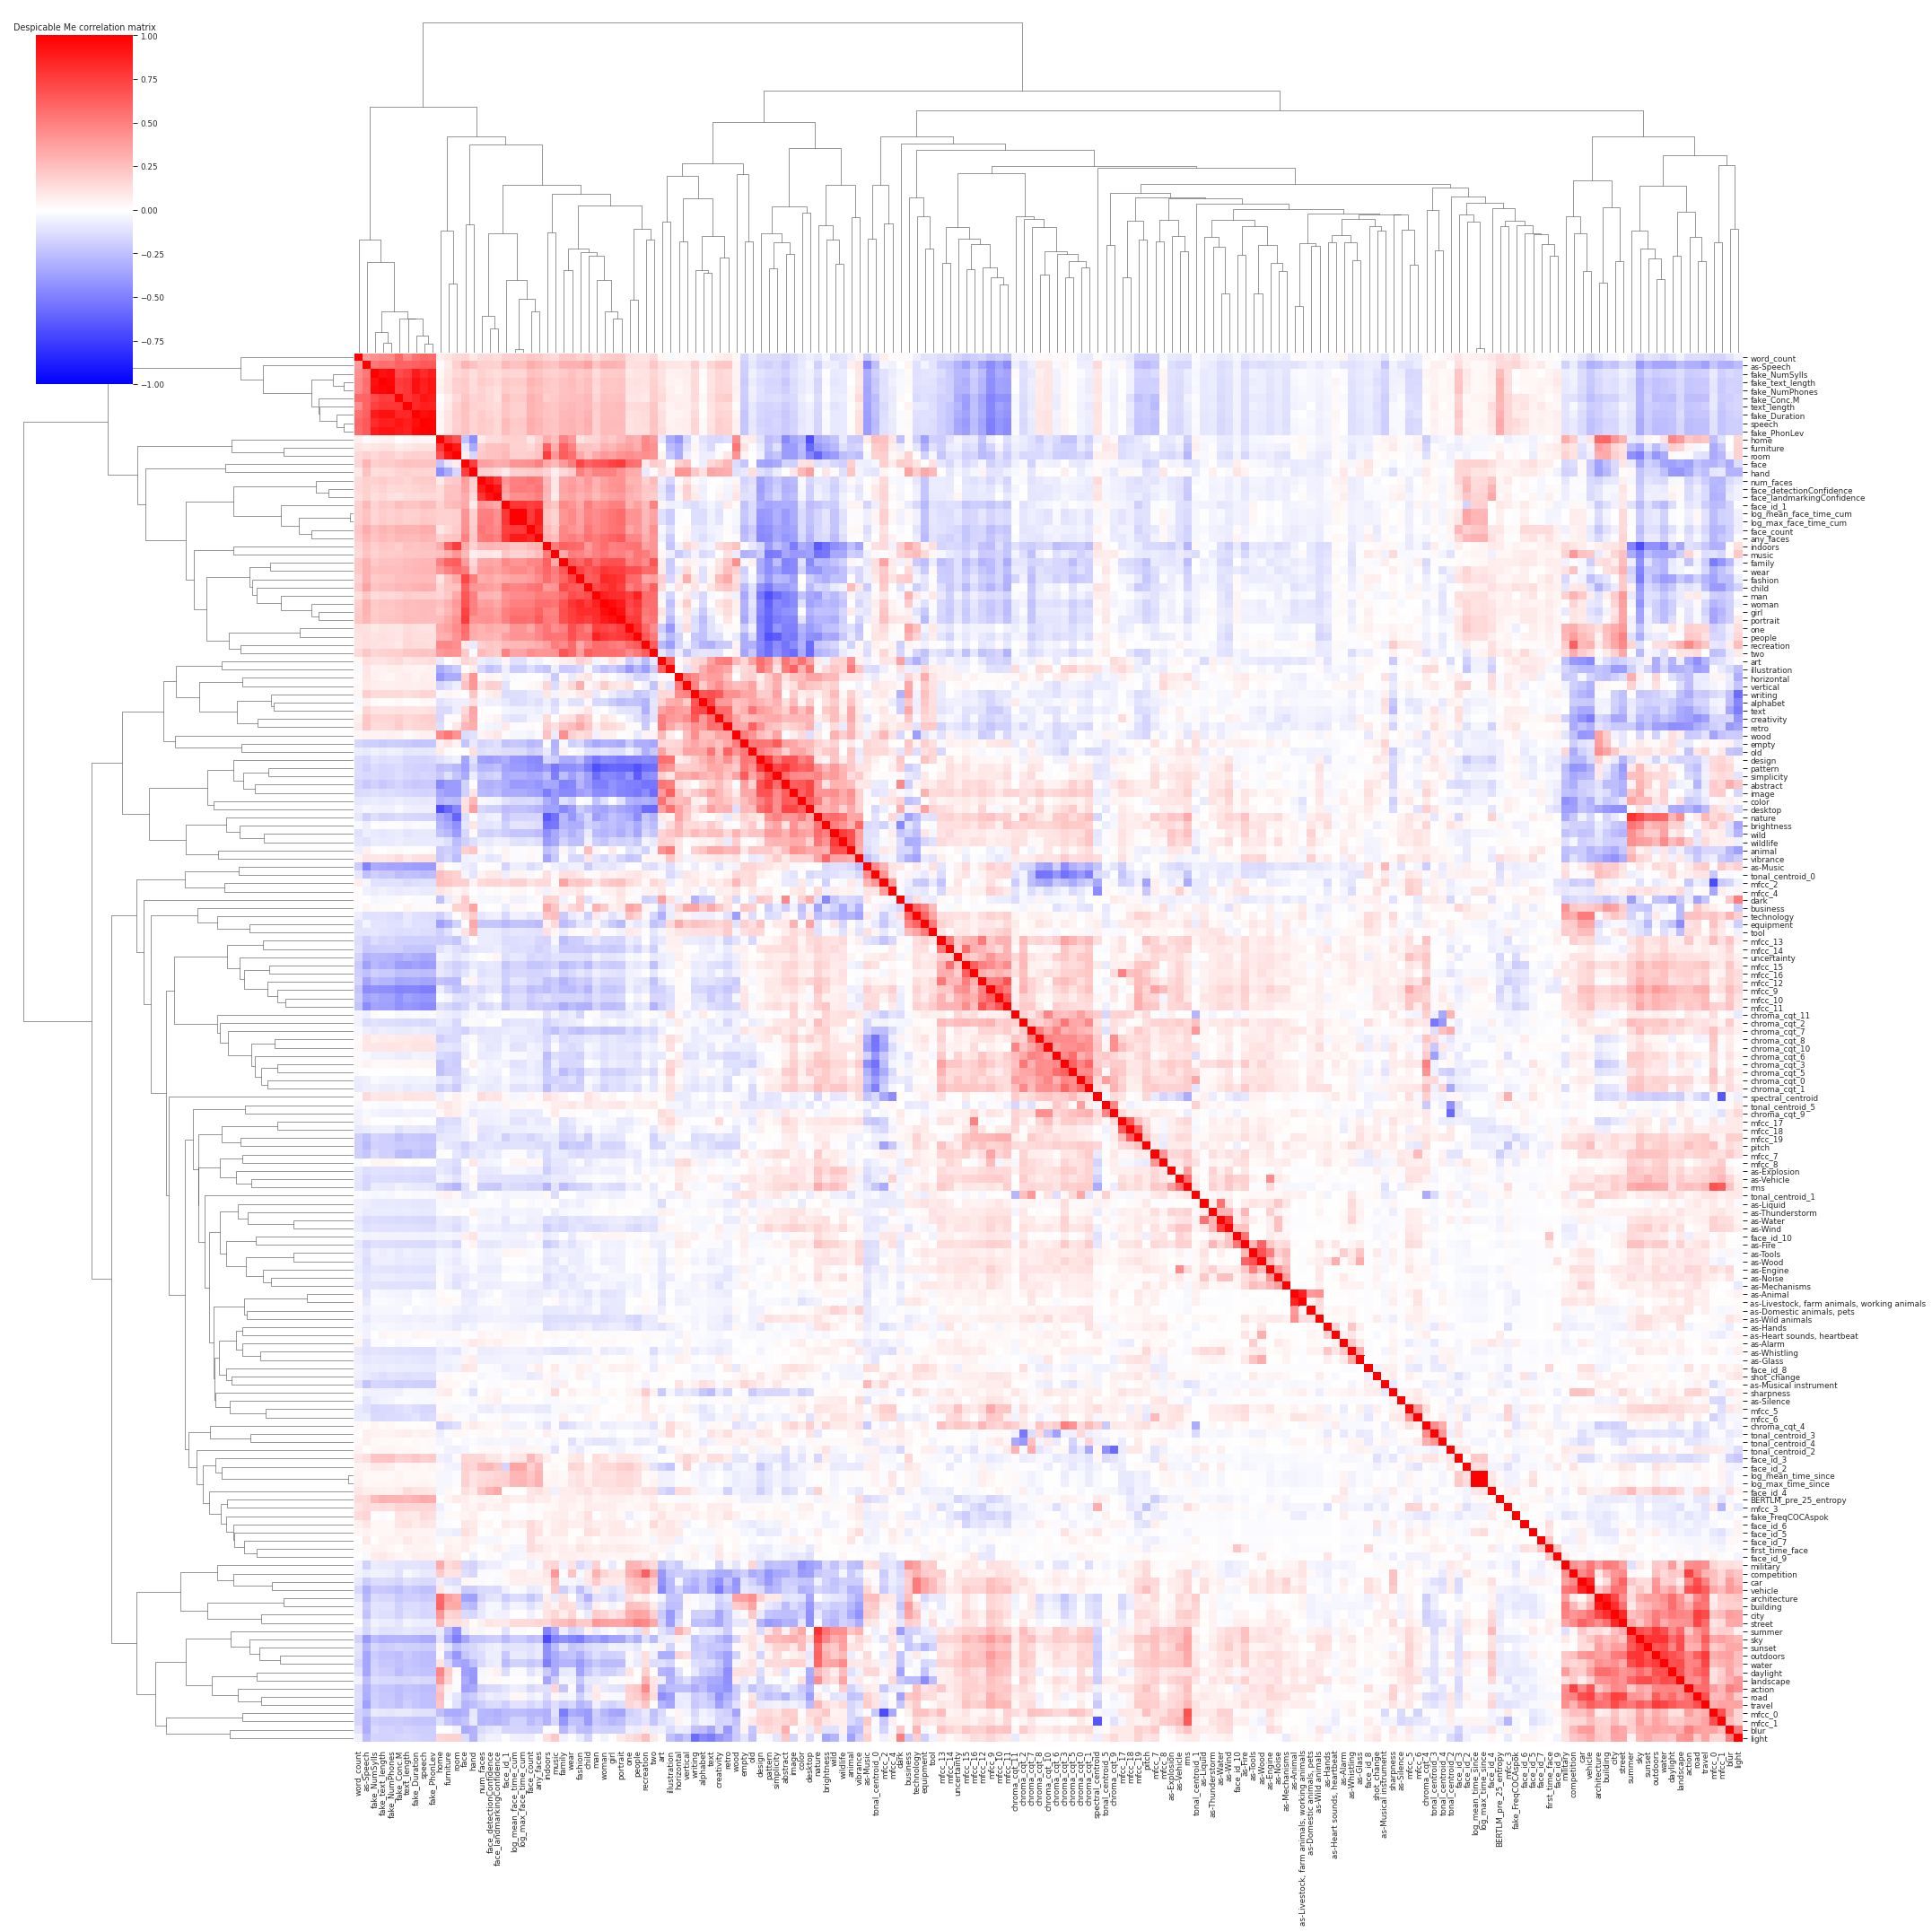

In [28]:
df_corr = df.corr()
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.clustermap(df_corr, cmap="bwr",figsize=(30, 30), vmin=-1, vmax=1, xticklabels=True, yticklabels=True)
plt.title("Despicable Me correlation matrix")